In [ ]:
import pandas as pd
import h5py
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
from pathlib import Path

import itertools as it

# plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from utils import get_datasets_and_learner_zoo_for_excluded_learners

from meta_feature import dataset_ids_CC18

In [2]:
excluded_learners = ["QDA", "DummyClassifier"]
learner_zoo, learner_zoo_abbreviated, dataset_nofs, dataset_minmaxfs, dataset_standardfs = get_datasets_and_learner_zoo_for_excluded_learners(excluded_learners)

In [3]:
def does_lc1_start_higher_than_lc2(lc1, lc2):
    valid_indices_lc1 = np.where(~np.isnan(lc1))[0]
    valid_indices_lc2 = np.where(~np.isnan(lc2))[0]
    if len(valid_indices_lc1) == 0 or len(valid_indices_lc2) == 0:
        return False
    return lc1[0] > lc2[0]

def does_curve1_cross_curve2_from_above(lc1, lc2, cross_mode="start_end_comparison"):
    if cross_mode == "start_end_comparison":
        valid_indices_lc1 = np.where(~np.isnan(lc1))[0]
        valid_indices_lc2 = np.where(~np.isnan(lc2))[0]
        if len(valid_indices_lc1) == 0 or len(valid_indices_lc2) == 0:
            return False
        highest_valid_index = min(max(valid_indices_lc1), max(valid_indices_lc2))
        return lc1[0] > lc2[0] and lc1[highest_valid_index] < lc2[highest_valid_index]

def get_cross_counts_over_contexts(lcs):
    cross_counts = np.zeros((lcs.shape[0], lcs.shape[1], lcs.shape[1]))
    for k, lcs_in_context in enumerate(lcs):
        for i, lc1 in enumerate(lcs_in_context):
            for j, lc2 in enumerate(lcs_in_context):
                cross_counts[k, i, j] = does_curve1_cross_curve2_from_above(lc1, lc2)
    return cross_counts

def get_prob_matrices(lcgs):

    # compute diffs at different anchors
    lc1_starts_higher_than_lc2_count = np.zeros((lcgs.shape[0], lcgs.shape[1], lcgs.shape[1]))
    cross_counts = get_cross_counts_over_contexts(lcs=lcgs)
    for k, lcs_in_context in enumerate(lcgs):
        for i, lc1 in enumerate(lcs_in_context):
            for j, lc2 in enumerate(lcs_in_context):
                lc1_starts_higher_than_lc2_count[k, i, j] = does_lc1_start_higher_than_lc2(lc1, lc2)
    
    # compute P(A starts lower than B)
    probs_a_starts_higher_than_b = lc1_starts_higher_than_lc2_count.mean(axis=0)
    
    # compute P(A starts lower than B and finishes higher)
    probs_a_starts_higher_than_b_and_ends_lower_than_b = cross_counts.mean(axis=0)
    return probs_a_starts_higher_than_b, probs_a_starts_higher_than_b_and_ends_lower_than_b

### Find Combinations that cross most and least

In [4]:
DATASET = dataset_minmaxfs

In [5]:
probs_a_starts_higher_than_b, probs_a_starts_higher_than_b_and_ends_lower_than_b = get_prob_matrices(lcgs=DATASET[:, :, :, :, :, 1].mean(axis=(2, 3)))
#probs_of_crossing = probs_a_starts_higher_than_b_and_ends_lower_than_b / probs_a_starts_higher_than_b
#probs_of_crossing[np.isnan(probs_of_crossing)] = 0

probs_of_crossing = probs_a_starts_higher_than_b_and_ends_lower_than_b

k = 5
rows = []
for learners in tqdm(list(it.combinations(range(len(learner_zoo)), k))):
    sub_matrix = probs_of_crossing[list(learners)][:, list(learners)]
    rows.append(list(learners) + [np.mean(sub_matrix)])

100%|██████████| 26334/26334 [00:00<00:00, 76056.96it/s]


In [6]:
learner_cols = [f"learner {i}" for i in range(1, k + 1)]
df_cross_counts = pd.DataFrame(rows, columns=learner_cols + ["avg prob of crossing"])
for col in learner_cols:
    df_cross_counts[col] = df_cross_counts[col].apply(lambda c: learner_zoo[c])
display(df_cross_counts.sort_values("avg prob of crossing", ascending=True).head())
display(df_cross_counts.sort_values("avg prob of crossing", ascending=False).head())
most_crossing_learners = list(df_cross_counts.sort_values("avg prob of crossing", ascending=False).iloc[0][learner_cols])
least_crossing_learners = list(df_cross_counts.sort_values("avg prob of crossing", ascending=True).iloc[0][learner_cols])
print(least_crossing_learners)
print(most_crossing_learners)

,learner 1,learner 2,learner 3,learner 4,learner 5,avg prob of crossing
14823,SVM_Sigmoid,Decision Tree,ExtraTree,ens.ExtraTrees,ens.RandomForest,0.057222
15778,SVM_Sigmoid,ExtraTree,SGDClassifier,ens.ExtraTrees,ens.RandomForest,0.061667
15945,SVM_Sigmoid,ExtraTree,ens.ExtraTrees,ens.RandomForest,ens.GradientBoosting,0.062222
14824,SVM_Sigmoid,Decision Tree,ExtraTree,ens.ExtraTrees,ens.GradientBoosting,0.062778
18325,Decision Tree,ExtraTree,ens.ExtraTrees,ens.RandomForest,ens.GradientBoosting,0.063889


,learner 1,learner 2,learner 3,learner 4,learner 5,avg prob of crossing
13897,SVM_RBF,Perceptron,LDA,KNN,NearestCentroid,0.220556
13500,SVM_RBF,PassiveAggressive,SGDClassifier,LDA,NearestCentroid,0.216667
23908,PassiveAggressive,SGDClassifier,LDA,KNN,NearestCentroid,0.216111
24623,Perceptron,SGDClassifier,LDA,KNN,NearestCentroid,0.215556
14282,SVM_RBF,SGDClassifier,LDA,KNN,NearestCentroid,0.215556


['SVM_Sigmoid', 'Decision Tree', 'ExtraTree', 'ens.ExtraTrees', 'ens.RandomForest']
['SVM_RBF', 'Perceptron', 'LDA', 'KNN', 'NearestCentroid']


In [7]:
# #for dataset_idx in range(70):
# plotted_learners = least_crossing_learners

# plotted_learners_idxs = [learner_zoo.index(l) for l in plotted_learners]
# for dataset_idx in [dataset_ids_CC18.index(id) for id in [16, 37, 38, 46, 554, 1067, 1468, 1475, 1480, 40668]]:
#     fig, axs = plt.subplots(1, 5, figsize=(30, 5))
#     for outer_seed, ax in enumerate(axs):
#         curves = DATASET[dataset_idx, plotted_learners_idxs, outer_seed, :, :, 1].mean(axis=(1)).T
#         ax.plot(curves, label=plotted_learners)
#         ax.set_title(f"test seed = {outer_seed}")
#         ax.legend()
#         ax.grid()
#     fig.suptitle(dataset_ids_CC18[dataset_idx])
#     fig.tight_layout()
#     plt.show()

In [8]:
def plot_learning_curve_crossing_probabilities(lcgs, learners=None, axs=None, heatmap_kwargs={}):
    
    print(f"Computing crossings of curves based on {lcgs.shape} data, i.e., {lcgs.shape[1]} algorithms on {lcgs.shape[2]} anchors for {lcgs.shape[0]} contexts.")
    

    learner_indices = range(lcgs.shape[1]) if learners is None else [learner_zoo.index(i) for i in learners]
    learner_names_abbr = [learner_zoo_abbreviated[i] for i in learner_indices]

    probs_a_starts_higher_than_b, probs_a_starts_higher_than_b_and_ends_lower_than_b = get_prob_matrices(lcgs[:, learner_indices])
    
    # figure for probability of crossing
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(8, 3), dpi = 400)
    
    heatmap_kwargs["vmin"] = 0
    heatmap_kwargs["vmax"] = 1
    if "cmap" not in heatmap_kwargs:
        heatmap_kwargs["cmap"] = "Greens"
    
    sb.heatmap(probs_a_starts_higher_than_b, **heatmap_kwargs, ax=axs[0])
    sb.heatmap(probs_a_starts_higher_than_b_and_ends_lower_than_b, **heatmap_kwargs, ax=axs[1])
    sb.heatmap(probs_a_starts_higher_than_b_and_ends_lower_than_b / np.maximum(10**-10, probs_a_starts_higher_than_b), **heatmap_kwargs, ax=axs[2])
    axs[0].set_title(r"$\mathrm{P}$(A starts higher than B)", fontsize = 18, pad=16)
    axs[1].set_title(r"$\mathrm{P}$(A starts higher than B and ends lower)", fontsize = 18, pad=16)
    axs[2].set_title(r"$\mathrm{P}$(A and ends lower than B $|$ A starts higher than B)", fontsize = 18, pad=16)
    for ax in axs:
        ax.set_xlabel("Learner A", fontsize = 16)
        # ax.set_ylabel("Learner B", fontsize = 16)
        ax.set_xticks(np.arange(len(learner_names_abbr)) + 0.5)
        ax.set_yticks(np.arange(len(learner_names_abbr)) + 0.5)
        ax.set_xticklabels(learner_names_abbr, rotation=90)
        ax.set_yticklabels(learner_names_abbr, rotation=0)
    axs[0].set_ylabel("Learner B", fontsize = 16)
    print(f"Overall probability that two learning curves will cross is {np.round(100 * probs_a_starts_higher_than_b_and_ends_lower_than_b.mean(), 2)}%")

[ 0  1  2  3  4 12]
(72, 22, 5, 5, 137, 3) (72, 22, 137)
SVM_Linear 
	7.77% crossing other from above 
	20.64% being cross by other from above
SVM_Poly 
	21.02% crossing other from above 
	9.53% being cross by other from above
SVM_RBF 
	31.44% crossing other from above 
	6.0% being cross by other from above
SVM_Sigmoid 
	6.12% crossing other from above 
	14.77% being cross by other from above
Decision Tree 
	15.78% crossing other from above 
	11.05% being cross by other from above
ExtraTree 
	13.83% crossing other from above 
	10.16% being cross by other from above
LogisticRegression 
	11.11% crossing other from above 
	15.66% being cross by other from above
PassiveAggressive 
	6.44% crossing other from above 
	24.18% being cross by other from above
Perceptron 
	8.78% crossing other from above 
	16.92% being cross by other from above
RidgeClassifier 
	13.76% crossing other from above 
	18.43% being cross by other from above
SGDClassifier 
	12.31% crossing other from above 
	13.89% bein

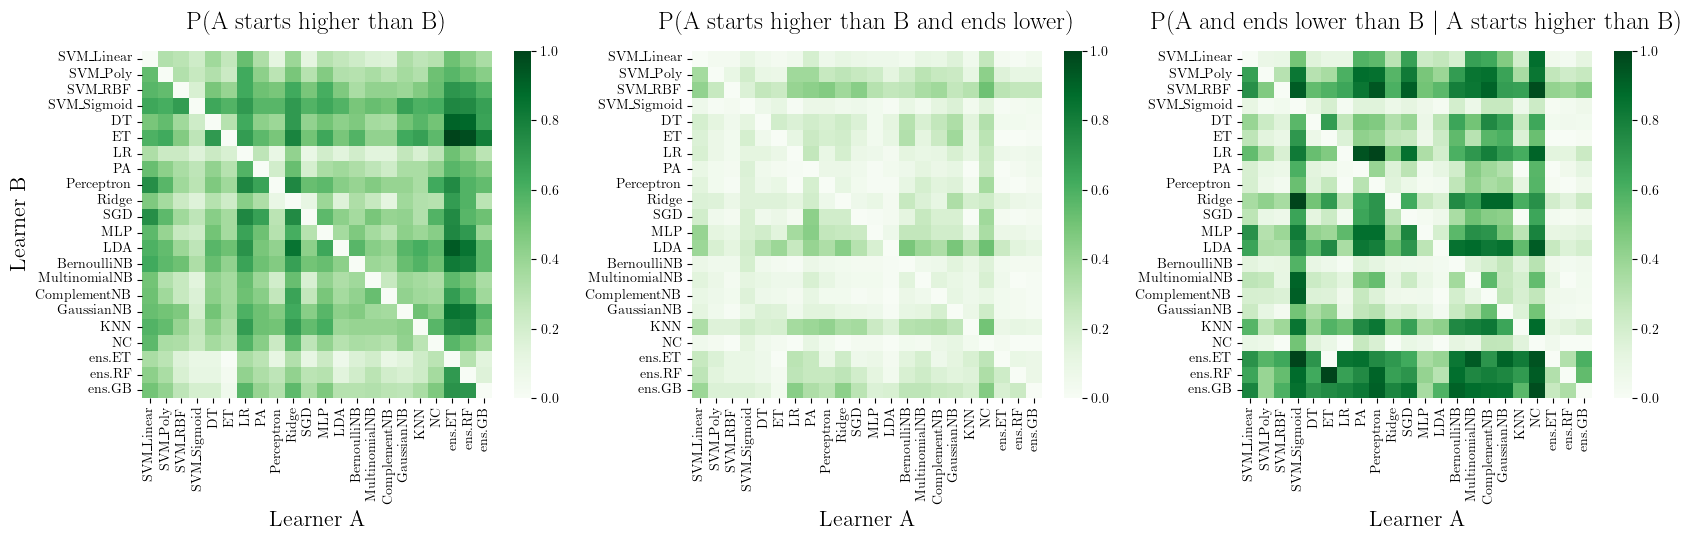

In [10]:
learner_idxs = np.array([0, 1, 2, 3, 4, learner_zoo.index("LDA")])#, -3, -2])
print(learner_idxs)

mean_validation_curves = dataset_nofs[:, :, :, :, :, 1].mean(axis=(2, 3))
print(dataset_nofs.shape, mean_validation_curves.shape)

cross_counts = get_cross_counts_over_contexts(lcs=mean_validation_curves)
for i, l in enumerate(learner_zoo):
    print(l, f"\n\t{np.round(100 * cross_counts[:, i].mean(), 2)}% crossing other from above", f"\n\t{np.round(100 * cross_counts[:, :, i].mean(), 2)}% being cross by other from above")

fig, axs = plt.subplots(1, 3, figsize=(17, 5.5))
plot_learning_curve_crossing_probabilities(mean_validation_curves, axs=axs)
fig.tight_layout()
fig.savefig(f"plots/lc_crossing_probs.pdf", bbox_inches="tight")
plt.show()

Computing crossings of curves based on (72, 22, 137) data, i.e., 22 algorithms on 137 anchors for 72 contexts.
Overall probability that two learning curves will cross is 6.28%


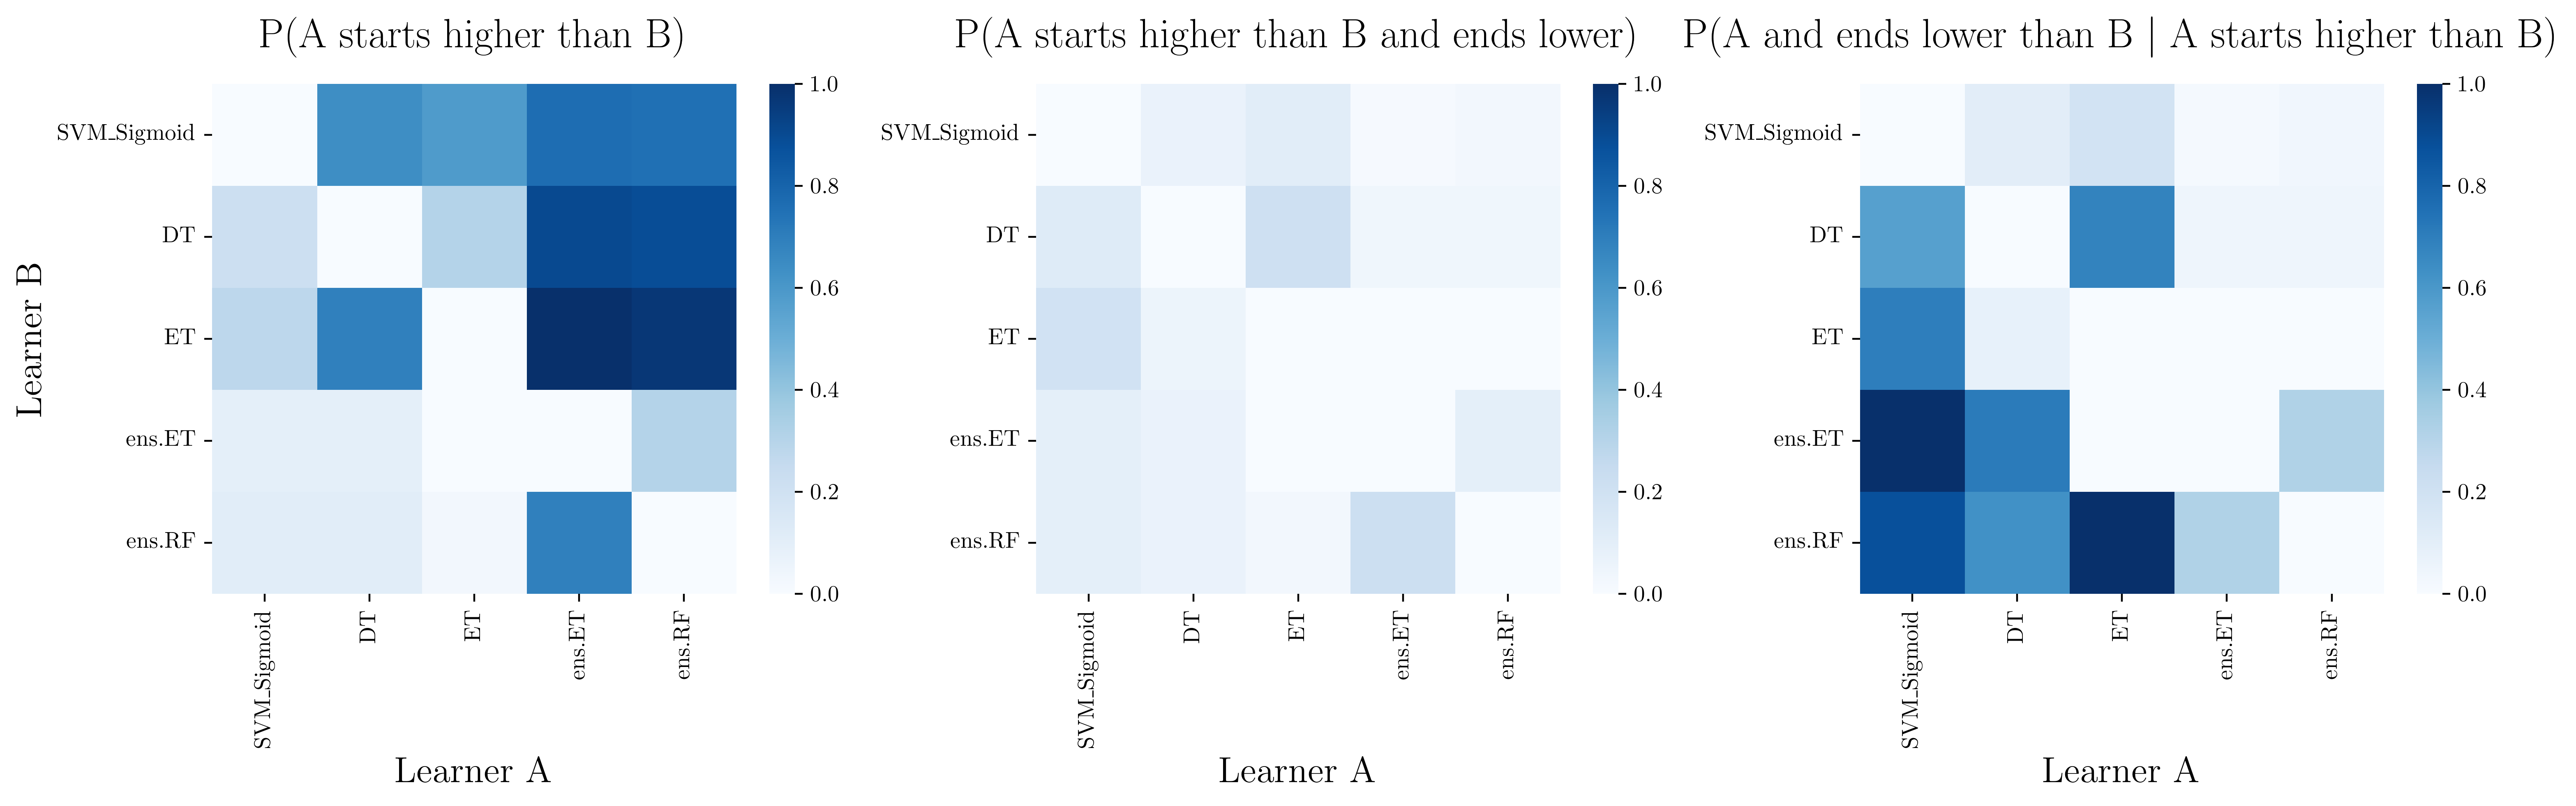

Computing crossings of curves based on (72, 22, 137) data, i.e., 22 algorithms on 137 anchors for 72 contexts.
Overall probability that two learning curves will cross is 18.39%


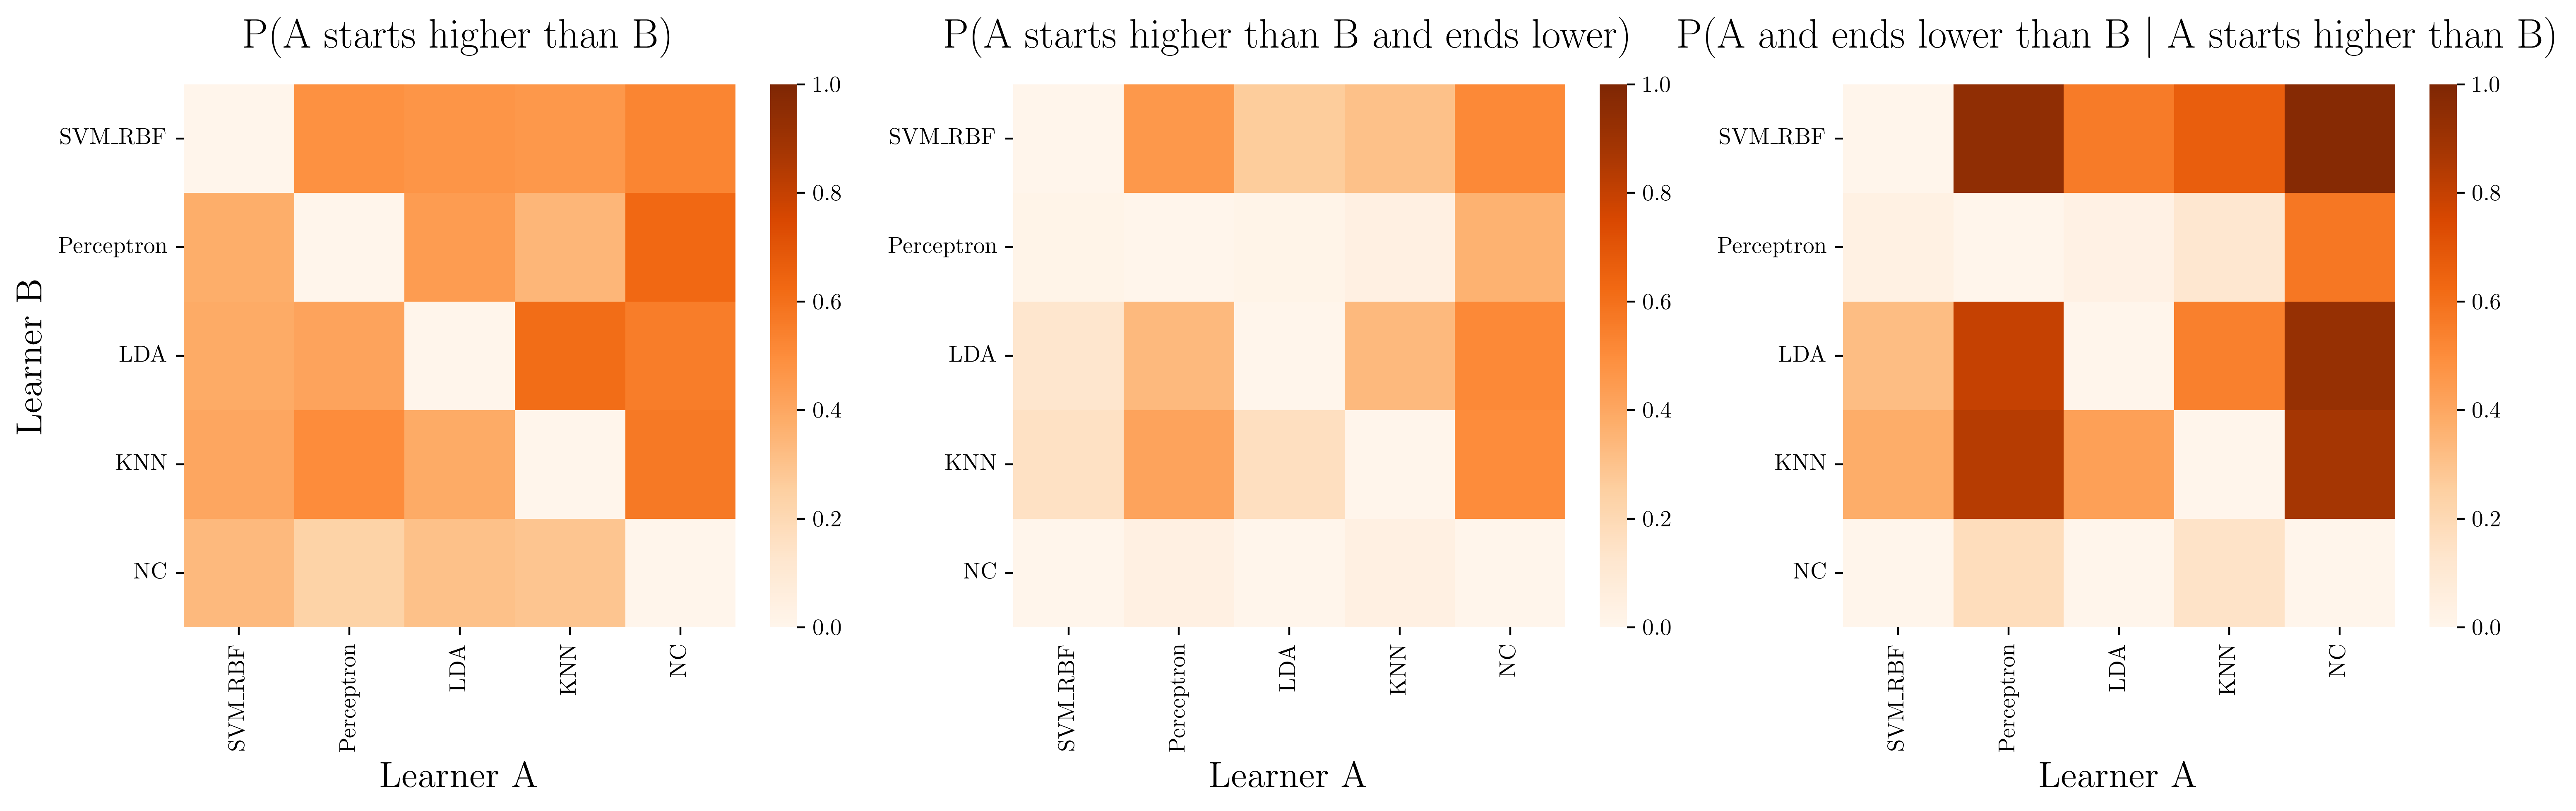

In [11]:
figsize = (15.5, 5)

fig, axs = plt.subplots(1, 3, figsize=figsize, dpi = 400)
plot_learning_curve_crossing_probabilities(mean_validation_curves, learners=least_crossing_learners, heatmap_kwargs={"cmap": "Blues"}, axs=axs)
fig.tight_layout()
fig.savefig(f"plots/lc_crossing_probs_least_crossing.pdf", bbox_inches="tight")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=figsize, dpi = 400)
plot_learning_curve_crossing_probabilities(mean_validation_curves, learners=most_crossing_learners, heatmap_kwargs={"cmap": "Oranges"}, axs=axs)
fig.tight_layout()
fig.savefig(f"plots/lc_crossing_probs_most_crossing.pdf", bbox_inches="tight")
plt.show()

Computing middle crossing probability heatmap from data shape (72, 22, 137).
Mean crossing probability: 6.28%
Computing middle crossing probability heatmap from data shape (72, 22, 137).
Mean crossing probability: 18.39%


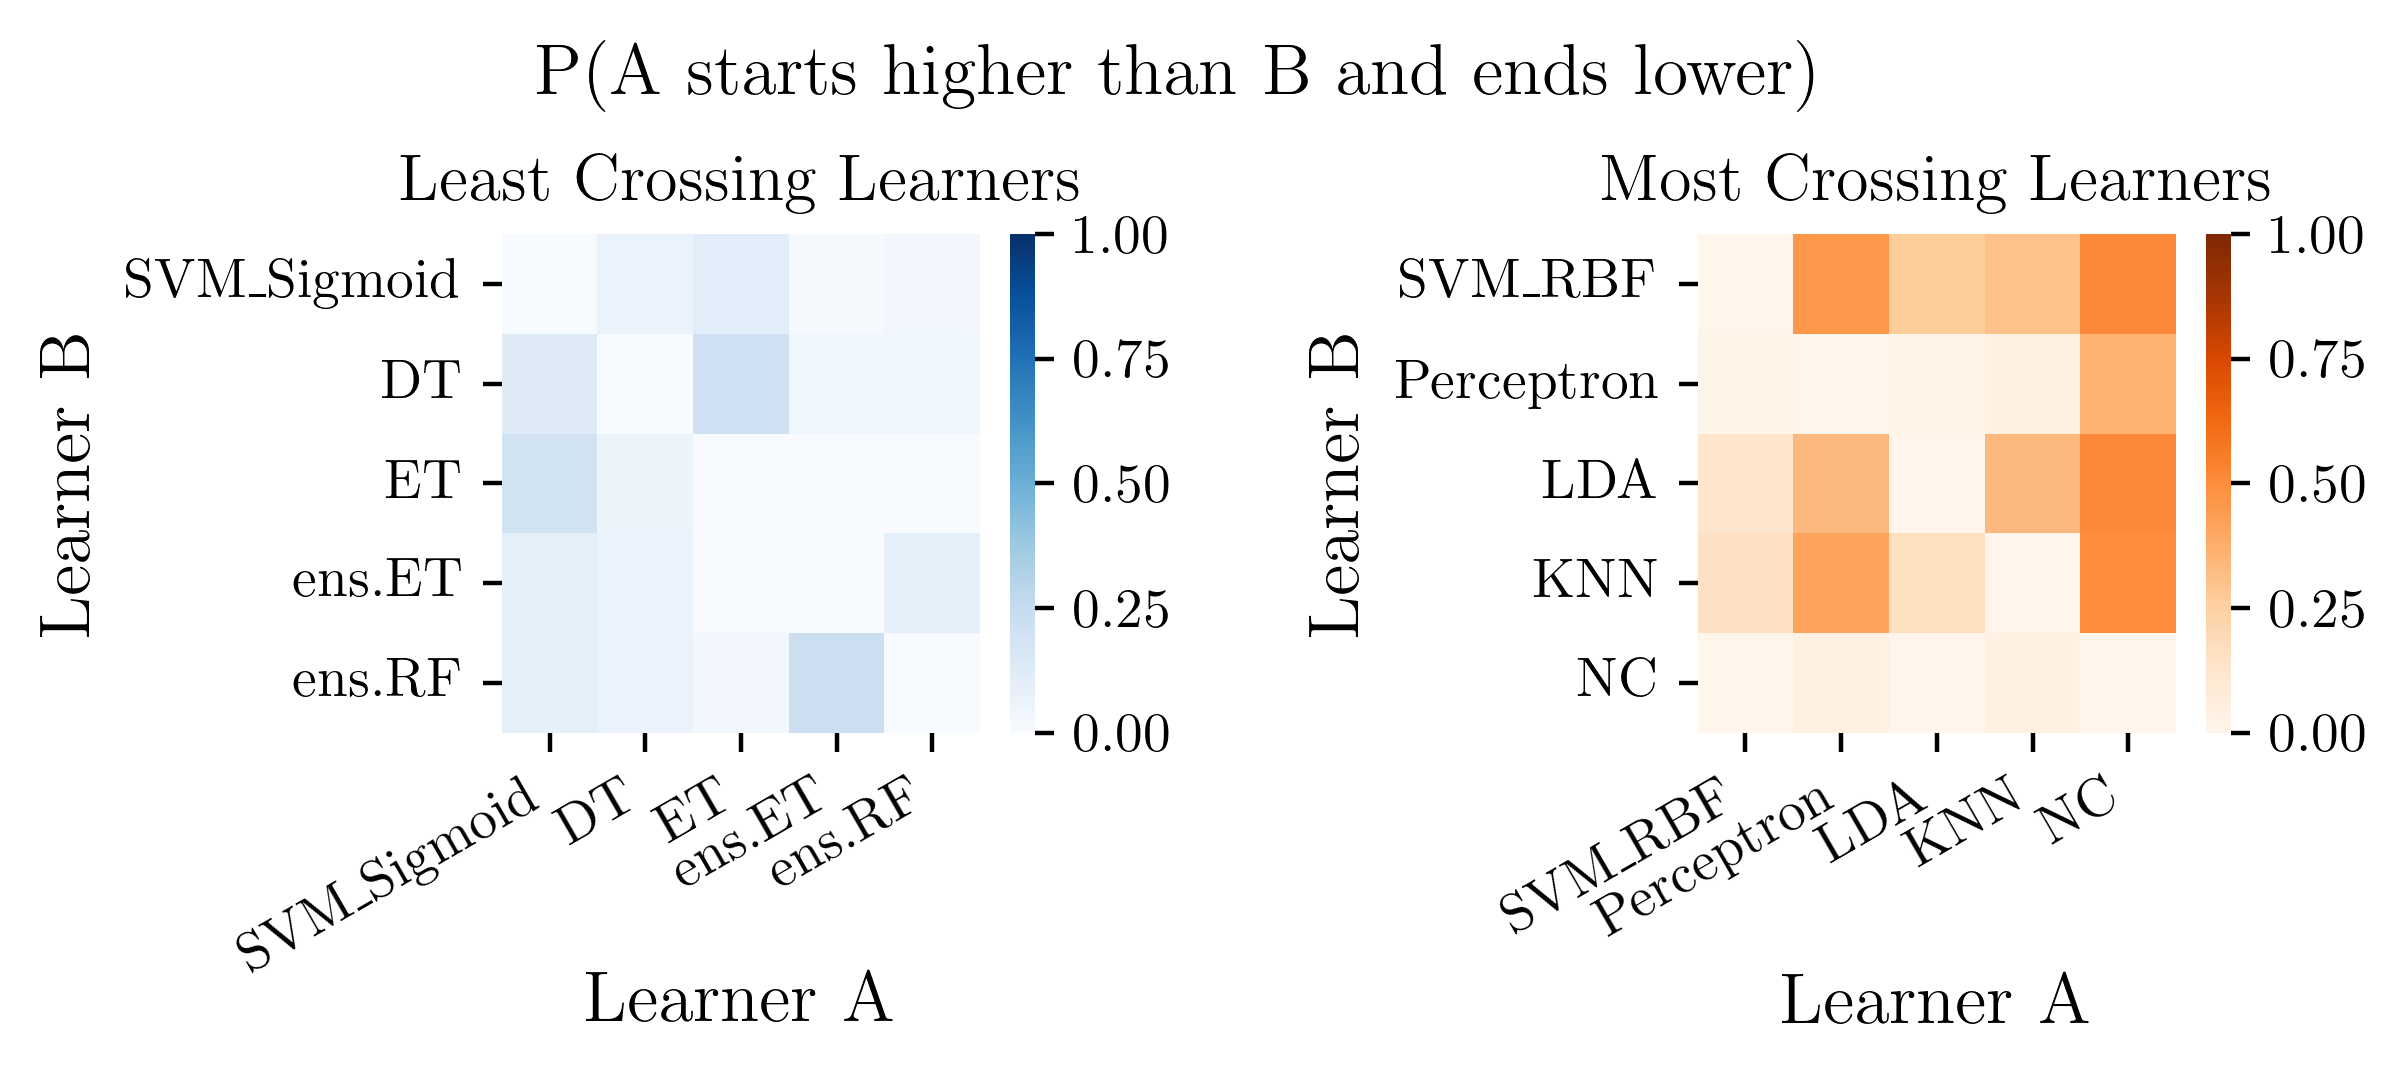

In [22]:
def plot_crossing_heatmap_only_prob(lcgs, learners=None, ax=None, heatmap_kwargs={}):
    print(f"Computing middle crossing probability heatmap from data shape {lcgs.shape}.")

    learner_indices = range(lcgs.shape[1]) if learners is None else [learner_zoo.index(i) for i in learners]
    learner_names_abbr = [learner_zoo_abbreviated[i] for i in learner_indices]

    _, probs_middle = get_prob_matrices(lcgs[:, learner_indices])
    
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4), dpi=400)

    heatmap_kwargs.setdefault("vmin", 0)
    heatmap_kwargs.setdefault("vmax", 1)
    heatmap_kwargs.setdefault("cmap", "Greens")

    sb.heatmap(probs_middle, **heatmap_kwargs, ax=ax)

    # ax.set_title(r"$\mathrm{P}$(A starts higher than B and ends lower)", fontsize=13, pad=16)
    # ax.set_xlabel("Learner A", fontsize=13)
    # # ax.xaxis.set_label_coords(0.5, -0.4)
    # ax.set_xlabel("Learner A", fontsize=13, labelpad=10)
    ax.set_ylabel("Learner B", fontsize=13)
    # ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.set_xticks(np.arange(len(learner_names_abbr)) + 0.5)
    ax.set_yticks(np.arange(len(learner_names_abbr)) + 0.5)
    ax.set_xticklabels(learner_names_abbr, rotation=30, ha='right')
    ax.set_yticklabels(learner_names_abbr, rotation=0)

    print(f"Mean crossing probability: {np.round(100 * probs_middle.mean(), 2)}%")

fig, axs = plt.subplots(1, 2, figsize=(6, 2.7), dpi=400)

plot_crossing_heatmap_only_prob(mean_validation_curves, learners=least_crossing_learners, heatmap_kwargs={"cmap": "Blues"}, ax=axs[0])
axs[0].set_title("Least Crossing Learners")

plot_crossing_heatmap_only_prob(mean_validation_curves, learners=most_crossing_learners, heatmap_kwargs={"cmap": "Oranges"}, ax=axs[1])
axs[1].set_title("Most Crossing Learners")

axs[0].set_xlabel("Learner A", fontsize=13, labelpad=-2)
axs[1].set_xlabel("Learner A", fontsize=13, labelpad=5)

fig.suptitle(r"$\mathrm{P}$(A starts higher than B and ends lower)", fontsize=13)
# fig.supxlabel("Learner A", fontsize=13)
# fig.supylabel("Learner B", fontsize=13)

fig.tight_layout()
fig.subplots_adjust(top=0.80, wspace=1.0)  
fig.savefig("plots/lc_crossing_probs_comparison.pdf", bbox_inches="tight")
plt.show()
